In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#### TODO install geopandas
#import geopandas as gp
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, csr_matrix

In [225]:
#feed in standardized data
#need to do a DF.to_csv from the other files
df_form = pd.read_csv("formationout.csv")
df_well = pd.read_csv("out.csv")
#Merge the 2 CSVs by API number
df_merged = df_well.merge(df_form, how = "left", on = "API Number")
print(df_merged.head())



     API Number  Northing   Easting  True Vertical Depth  Normalized TVD  \
0  490251039700  974652.3  794810.9              -2007.0        0.451998   
1  490251039700  974652.3  794810.9              -2007.0        0.451998   
2  490251039700  974652.3  794810.9              -2007.0        0.451998   
3  490251039700  974652.3  794810.9              -2007.0        0.451998   
4  490251039700  974652.3  794810.9              -2007.0        0.451998   

  Well Number  Form Alias   Top MD  
0     34-A-21        22.0  1564.04  
1     34-A-21        19.0   910.29  
2     34-A-21        10.0  2785.42  
3     34-A-21        20.0  1461.42  
4     34-A-21        23.0   527.25  


In [226]:
#make a sparse matrix from the dataframe
D_df = df_merged.pivot_table("Top MD","Form Alias","API Number").fillna(0)
D_df

API Number,490250632500,490250632700,490250632800,490250632900,490250633200,490250633400,490250633800,490250633900,490250634000,490250634100,...,490252284701,490252303100,490252304000,490252304700,490252304800,490252305400,490252305500,490252319500,490252345102,490252347904
Form Alias,,,,,,,,,,,,,,,,,,,,,
0.0,659.21,877.38,758.13,1008.06,1153.97,878.61,0.00,995.26,736.08,864.05,...,0.00,360.260,272.85,573.410,0.000,350.620,1109.54,224.740,215.69,0.00
1.0,295.64,503.67,403.90,636.30,784.37,514.77,0.00,636.98,359.02,488.76,...,0.00,0.000,0.00,196.090,0.000,0.000,662.67,0.000,0.00,0.00
2.0,246.11,455.35,356.96,587.49,737.05,469.29,0.00,593.88,310.83,441.42,...,0.00,0.000,0.00,151.630,0.000,0.000,616.08,0.000,0.00,0.00
3.0,745.70,963.16,845.31,1095.43,1245.16,965.34,0.00,1085.68,824.01,951.11,...,0.00,441.700,356.67,667.490,0.000,438.070,1187.81,311.840,302.07,0.00
4.0,0.00,0.00,917.85,1166.07,1313.05,1035.14,0.00,1156.66,0.00,1021.27,...,0.00,517.560,428.40,0.000,0.000,511.170,1266.07,386.040,376.00,0.00
5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1872.960,0.00,2083.850,1958.530,1854.770,0.00,1758.000,1793.86,0.00
6.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,2092.950,0.00,2318.600,2191.500,2096.960,0.00,1994.000,2017.55,2037.50
7.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,2313.800,2207.91,2543.050,2416.135,2314.750,0.00,2222.000,2238.18,2262.85
8.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,2545.010,2447.05,2785.600,2663.945,2558.720,0.00,2470.840,2474.86,2505.13


Trying different ways of normalizing R, demeaning and normalizing with SKLearn

In [227]:
R = D_df.values
well_depth_mean = np.mean(R, axis = 1)
R_normalize = normalize(R, norm = "max")
R_demeaned = R - well_depth_mean.reshape(-1, 1)

Create binarized matrix with values of 1 where there are non-zero values in the sparse matrix R and values of 0 where there are zero values in the sparse matrix R.

In [228]:
from sklearn.preprocessing import binarize
A = binarize(R)

This is the important part of the notebook, everything else as far as I can tell is just reshaping and manipulating data.

In [229]:
#ALS factorization from 
# https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
# here items are the formation and users are the well
def runALS(A, R, n_factors, n_iterations, lambda_):
    """
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    """
    print("Initiating ")
    lambda_ = lambda_
    n_factors = 20
    n, m = A.shape
    n_iterations = n_iterations
    Users = 5 * np.random.rand(n, n_factors)
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MSE_List = []

    print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(
                np.dot(Items, np.dot(np.diag(Ri), Items.T))
                + lambda_ * np.eye(n_factors),
                np.dot(Items, np.dot(np.diag(Ri), A[i].T)),
            ).T
        print(
            "Error after solving for User Matrix:",
            get_error(A, Users, Items, R),
        )

        for j, Rj in enumerate(R.T):
            Items[:, j] = np.linalg.solve(
                np.dot(Users.T, np.dot(np.diag(Rj), Users))
                + lambda_ * np.eye(n_factors),
                np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])),
            )
        print(
            "Error after solving for Item Matrix:",
            get_error(A, Users, Items, R),
        )

        MSE_List.append(get_error(A, Users, Items, R))
        print("%sth iteration is complete..." % iter)
    return Users, Items
    # print(MSE_List)
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    # plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    # plt.savefig('Python MSE Graph.pdf', format='pdf')
    # plt.show()

In [230]:
U, Vt = runALS(R_normalize, A, 10, 10, 0.1)

Initiating 
Starting Iterations
Error after solving for User Matrix: 0.014285120510719753
Error after solving for Item Matrix: 0.15884461138335884
0th iteration is complete...
Error after solving for User Matrix: 0.00417700933779033
Error after solving for Item Matrix: 0.0028485809863700046
1th iteration is complete...
Error after solving for User Matrix: 0.00016981908759903204
Error after solving for Item Matrix: 0.0012743153204959122
2th iteration is complete...
Error after solving for User Matrix: 0.00010645444778629625
Error after solving for Item Matrix: 0.000754200684724648
3th iteration is complete...
Error after solving for User Matrix: 8.189869450793534e-05
Error after solving for Item Matrix: 0.0005175396858538491
4th iteration is complete...
Error after solving for User Matrix: 6.946514505850892e-05
Error after solving for Item Matrix: 0.000380226275486052
5th iteration is complete...
Error after solving for User Matrix: 6.185607521035511e-05
Error after solving for Item Mat

In [231]:
recommendations = np.dot(U, Vt)
recsys_df = pd.DataFrame(data = recommendations[0:, 0:], index = D_df.index,
                        columns = D_df.columns)
recsys_df.head()

API Number,490250632500,490250632700,490250632800,490250632900,490250633200,490250633400,490250633800,490250633900,490250634000,490250634100,...,490252284701,490252303100,490252304000,490252304700,490252304800,490252305400,490252305500,490252319500,490252345102,490252347904
Form Alias,,,,,,,,,,,,,,,,,,,,,
0.0,0.437195,0.582571,0.505465,0.672355,0.770712,0.585787,0.490042,0.664703,0.488247,0.575600,...,0.421796,0.244265,0.188738,0.378736,0.623715,0.241164,0.736428,0.150844,0.143568,0.259267
1.0,0.258365,0.442700,0.354408,0.559521,0.690631,0.453056,0.629838,0.561510,0.315215,0.429906,...,0.475716,0.424836,0.445292,0.161265,0.461559,0.397201,0.586059,-0.098510,-0.129325,0.021139
2.0,0.225383,0.411797,0.322995,0.528936,0.661947,0.422659,0.577876,0.533168,0.282527,0.398100,...,0.480803,0.532054,0.559677,0.170472,0.500034,0.502497,0.552517,-0.098887,-0.157897,-0.008582
3.0,0.468888,0.606090,0.535559,0.694592,0.789176,0.611827,0.546911,0.687839,0.518274,0.602926,...,0.460687,0.278355,0.223034,0.426458,0.677958,0.272831,0.755200,0.192812,0.192453,0.305104
4.0,0.525866,0.662825,0.667948,0.848613,0.955494,0.753374,0.384342,0.841574,0.576533,0.743401,...,0.599854,0.379956,0.313710,0.678123,0.879743,0.375616,0.921740,0.286511,0.276410,0.407969


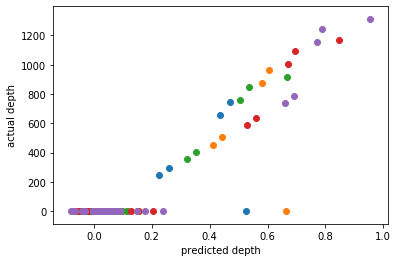

In [232]:
for i in range(5):
    plt.scatter(recsys_df.iloc[0:, i].values, D_df.iloc[0:, i].values) #plot predicted vs actual
    plt.xlabel('predicted depth')
    plt.ylabel('actual depth')
    plt.plot(np.arange(0,recsys_df.iloc[0:,i].max()))

Predicted depths

In [233]:
recsys_df.iloc[0:, 1]

Form Alias
0.0     0.582571
1.0     0.442700
2.0     0.411797
3.0     0.606090
4.0     0.662825
5.0     0.113845
6.0     0.098583
7.0     0.155097
8.0    -0.016205
9.0    -0.010630
10.0   -0.047054
11.0   -0.038972
12.0    0.027078
13.0    0.007102
14.0    0.003085
15.0    0.041570
16.0    0.033694
17.0    0.027275
18.0   -0.037287
19.0    0.018517
20.0   -0.021069
21.0    0.037846
22.0    0.049940
23.0    0.057444
24.0    0.056869
25.0    0.050077
26.0    0.042027
27.0    0.042763
28.0    0.047505
29.0    0.053911
30.0    0.053688
31.0    0.053198
32.0    0.052651
33.0    0.052705
34.0    0.039514
35.0    0.049119
36.0    0.027953
37.0    0.017489
38.0    0.052946
39.0    0.017489
40.0    0.038145
41.0    0.015246
42.0    0.017489
43.0    0.036825
44.0    0.027216
45.0    0.010538
46.0    0.011179
47.0    0.009255
48.0    0.011132
49.0    0.011112
50.0    0.011220
51.0    0.014424
52.0    0.011548
53.0    0.011513
54.0   -0.002122
55.0   -0.002122
56.0   -0.002122
57.0    0.047635
58.

Actual depths

In [234]:
D_df.iloc[0:, 1]

Form Alias
0.0     877.38
1.0     503.67
2.0     455.35
3.0     963.16
4.0       0.00
5.0       0.00
6.0       0.00
7.0       0.00
8.0       0.00
9.0       0.00
10.0      0.00
11.0      0.00
12.0      0.00
13.0      0.00
14.0      0.00
15.0      0.00
16.0      0.00
17.0      0.00
18.0      0.00
19.0      0.00
20.0      0.00
21.0      0.00
22.0      0.00
23.0      0.00
24.0      0.00
25.0      0.00
26.0      0.00
27.0      0.00
28.0      0.00
29.0      0.00
30.0      0.00
31.0      0.00
32.0      0.00
33.0      0.00
34.0      0.00
35.0      0.00
36.0      0.00
37.0      0.00
38.0      0.00
39.0      0.00
40.0      0.00
41.0      0.00
42.0      0.00
43.0      0.00
44.0      0.00
45.0      0.00
46.0      0.00
47.0      0.00
48.0      0.00
49.0      0.00
50.0      0.00
51.0      0.00
52.0      0.00
53.0      0.00
54.0      0.00
55.0      0.00
56.0      0.00
57.0      0.00
58.0      0.00
59.0      0.00
Name: 490250632700, dtype: float64